# Predicting demand of a bike sharing service

#### Applied prediction models: Linear regression, random forest, support vector regression 

This prediction task is based on a [Kaggle challenge](https://www.kaggle.com/c/bike-sharing-demand). Given is a dataset of Bikes rented at a station in Washington D.C. containing time and weather data as well as the number of bikes rented in the fist 19 days of a two year span. The task consists in predicting the demand in the remainding days of each month. 

### Loading necessary libraries

In [2]:
# importing libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# train test split library
from sklearn.model_selection import train_test_split

# importing ML libraries and evaluators 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

# importing evaluation libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing

# hyperparameter optimization w gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# supress warnings
import warnings
warnings.filterwarnings('ignore')

### Loading and preparing the dataset 

In [5]:
# loading the training dataset 
df = pd.read_csv('../bike_train.csv', index_col=0)

# prepare dataset & target  

data = df

X = data[data.columns].drop('count', axis=1)

y = data['count']

In [6]:
# train test splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Creating functions to clean and pre-process the data

In [7]:
# casting index to datetime

def time(dataset):
    '''Takes dataset with date time as index, 
    creates new columns year, month, hour'''
    dataset.index = pd.to_datetime(dataset.index)
    #creating new columns w datetime 
    dataset['year'] = dataset.index.year
    dataset['month'] = dataset.index.month
    dataset['weekday'] = dataset.index.weekday
    dataset['hour'] = dataset.index.hour
    return dataset

In [8]:
# Creating categorical bins of hour column values 

df = time(df)
labels = [1,2,3,4]
hour_bins = pd.qcut(df.groupby('hour')['count'].sum(), q=4, labels=labels).astype('int')

hour_frame = pd.DataFrame(hour_bins)

def binner(x):
    return hour_frame.loc[x]

In [9]:
# scaling function 

def scaling(dataset):
    #defining scaling clumns 
    columns = ['temp', 'atemp', 'humidity', 'windspeed']
    for feature in columns:
        # 1.convert the column value of the dataframe as floats
        float_array = dataset[feature].values.astype(float).reshape(-1, 1)
        # 2. create a min max processing object
        # scaler = preprocessing.MinMaxScaler() RobustScaler
        scaler = preprocessing.RobustScaler()
        scaled_array = scaler.fit_transform(float_array)
        # 3. add scaled array to dataframe
        dataset[feature] = scaled_array
    return dataset

In [10]:
# enigneering function 

def engin(dataset):
    """Takes a dataset, removes redundant columns, casts index to datetime, dummy encodes seasons, year, 
    and put hours in 4 buckets"""
    # removing redundant columns
    red_cols = ['registered', 'casual']
    for feature in red_cols:
        if feature in dataset.columns:
            dataset.drop(['registered', 'casual'], axis=1, inplace=True)
    # casting time to year, month, hour
    dataset = time(dataset)
    # dummy seasons 
    cat_cols = ['season']
    for feature in cat_cols:
        if feature in dataset.columns:
            dataset = pd.get_dummies(dataset,columns=cat_cols,drop_first=False)    
    # converting year in binary categories
    dataset.year = dataset.year.map({2011: 0, 2012: 1})    
    # converting hour to 4 categories 
    dataset.hour = dataset.hour.apply(binner)
    # scaling columns 
    dataset = scaling(dataset)
    return dataset

In [11]:
# Engineering the datasets to prepare them for model fitting 

X_eng = engin(X_train)
Xtest_eng = engin(X_test)

### Model fitting

In [12]:
# INSTANTIATING LINEAR MODEL
linear_model = LinearRegression()

# INSTANTIATING FOREST MODEL 
forest_model = RandomForestRegressor()

# INSTANTIATING SUPPORT VECTOR REGRESSOR
supvec_model = svm.SVR()

In [13]:
# model fitting and predicting y values

def model_fitter(model, trainset, target, testset):
    """Example values: model: linear_model, trainset: X_train, target: y_train, testset: X_test"""
    
    model.fit(trainset, target)
    y_pred = model.predict(testset)
    return y_pred

### Linear model: Fitting & predicting (Training data)

In [14]:
y_lin_default = model_fitter(linear_model, X_eng, y_train, Xtest_eng)

y_lin_default

array([181.77288555,  63.60146283, 296.85598845, ..., 322.24513777,
       -13.50127235, 381.23877974])

### Forest model: Fitting & predicting (Training data) 

In [15]:
y_for_default = model_fitter(forest_model, X_eng, y_train, Xtest_eng)

y_for_default

array([118.2,  68.8, 168.4, ..., 424. ,  15.1, 309.1])

In [16]:
mean_squared_log_error(y_test, y_for_default)

0.48541521104032775

### Forest model – hyperparameter optimized: Fitting & predicting (Training data)

In [17]:
# model has been instanciated above 

param_grid = {
    'max_depth': [1, 4, 8, 32, 128, None],
    'n_estimators': [1, 10, 100, 1000]
}

def grid_searcher(model, trainset, train_target):
    """Gives predicted y values and gridsearch model. 
    Example values: model: linear_model, trainset: X_train, target: y_train"""
    ranfor_random = RandomizedSearchCV(estimator = model, 
                                   param_distributions = param_grid, 
                                   return_train_score=True,
                                   cv=5, 
                                   n_jobs=2)
               
    # Fit the random search model
    ranfor_random.fit(trainset, train_target)
    return ranfor_random.best_estimator_

In [18]:
best_forest = grid_searcher(forest_model, X_eng, y_train)
best_forest

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=128,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [19]:
# best forest evaluating
y_bestforest = model_fitter(best_forest, X_eng, y_train, Xtest_eng)
y_bestforest

array([127.54886667, 101.612     , 159.437     , ..., 436.318     ,
        28.67668333, 353.44255   ])

In [20]:
# best forest score
mean_squared_log_error(y_test, y_bestforest)

0.4540832614253353

### Comparing the accuracy of predictions of different models 

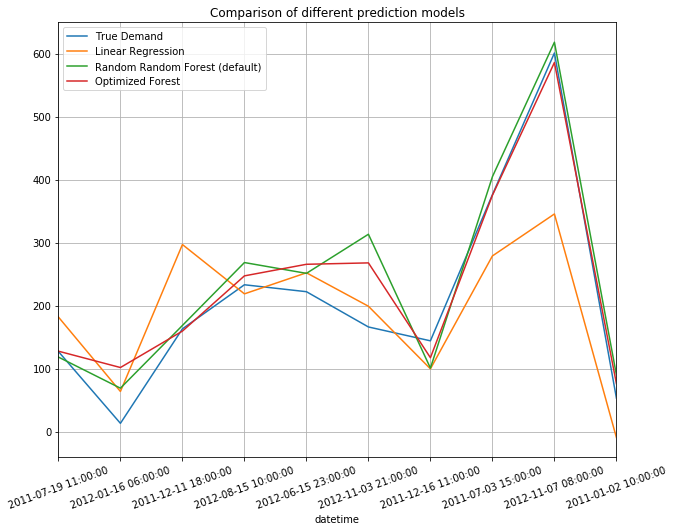

In [21]:
# plotting predicted values against 'y_test'

plot_frame = pd.DataFrame({'True Demand': y_test, 
                           'Linear Regression': y_lin_default, 
                           'Random Random Forest (default)': y_for_default, 
                          'Optimized Forest': y_bestforest})

#plt.figure(figsize=(10,8))
plot_frame.iloc[:10].plot(figsize=(10,8))
plt.title('Comparison of different prediction models')
plt.grid()
plt.xticks(rotation=20)
plt.savefig('bike_prediction_comparison.png')

### Fitting best model on test data

In [22]:
test = pd.read_csv('../bike_test.csv', index_col=0)

FileNotFoundError: [Errno 2] File b'bike_test.csv' does not exist: b'bike_test.csv'

In [ ]:
# eningeering datasets
X_final = scaling(engin(X))
test_final = scaling(engin(test))

In [ ]:
# fitting on test data and predicting
best_forest.fit(X_final, y)
y_pred = best_forest.predict(test_final)

In [ ]:
y_pred

### Printing results

In [ ]:
def sub_printer(dataset, test_results):
        
    # removing unnecessary columns
    for column in dataset.columns:
        if column in dataset.columns:
            dataset.drop(column, axis=1, inplace=True)
    
    dataset = dataset.reset_index()
    dataset['count'] = test_results
    dataset.set_index('datetime', inplace=True)
            
    return dataset
    # printing to csv
    # dataset.to_csv('bike_submission.csv', index=True, header =1)

In [ ]:
sub_printer(test_final, y_pred)